# Data Cleaning on Online Sales Data
- [Online Retail Sales Dataset](https://github.com/arnelimperial/greenergy/blob/d7b2a4cd417d148aa9ee5a76e94cd13e171c717c//href=)
- This dataset will provide synthetic data for online retail sales, which include details of customer transactions and orders with regard to the involved items, their quantities, prices, discounts, methods of payment, and the customers' demographics for analysis in terms of buying behavior, sales trend, inventory management, and marketing strategy.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
import statsmodels.api as sm
from scipy.stats import shapiro, normaltest, levene, zscore

In [2]:
# Set visual display settings
sns.set(style='whitegrid')

## Load CSV

In [3]:
original_df = pd.read_csv('online_retail_sales_dataset.csv')

In [4]:
original_df.head()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount
0,1,2023-01-01 00:00:00,1993,915,Home & Kitchen,8,103.30,0.23,Gift Card,27,Female,North America,636.33
1,2,2023-01-01 00:01:00,3474,553,Clothing,9,180.28,0.31,Gift Card,53,Other,South America,1119.54
2,3,2023-01-01 00:02:00,4564,248,Beauty & Personal Care,7,81.58,0.27,Debit Card,34,Other,North America,416.87
3,4,2023-01-01 00:03:00,1133,948,Clothing,3,235.20,0.00,Debit Card,50,Other,Australia,705.60
4,5,2023-01-01 00:04:00,3626,284,Books,9,453.00,0.34,Credit Card,23,Female,Australia,2690.82


## DF Overview

In [5]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 13 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   transaction_id     1000000 non-null  int64  
 1   timestamp          1000000 non-null  object 
 2   customer_id        1000000 non-null  int64  
 3   product_id         1000000 non-null  int64  
 4   product_category   1000000 non-null  object 
 5   quantity           1000000 non-null  int64  
 6   price              1000000 non-null  float64
 7   discount           1000000 non-null  float64
 8   payment_method     1000000 non-null  object 
 9   customer_age       1000000 non-null  int64  
 10  customer_gender    1000000 non-null  object 
 11  customer_location  1000000 non-null  object 
 12  total_amount       1000000 non-null  float64
dtypes: float64(3), int64(5), object(5)
memory usage: 99.2+ MB


In [6]:
original_df.shape
# (rows, columns)

(1000000, 13)

### Descriptive Statistics

In [7]:
# Descriptive stat of selected numeric columns
original_df[['quantity', 'price', 'discount', 'customer_age', 'total_amount']].describe()


,quantity,price,discount,customer_age,total_amount
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,5.003086,252.445705,0.250204,43.508625,946.839858
std,2.581004,142.868633,0.144384,15.007346,810.902205
min,1.000000,5.000000,0.000000,18.000000,2.560000
25%,3.000000,128.690000,0.130000,31.000000,297.180000
50%,5.000000,252.700000,0.250000,44.000000,715.710000
75%,7.000000,375.990000,0.380000,57.000000,1397.750000
max,9.000000,500.000000,0.500000,69.000000,4496.130000


## Data Cleaning

### Handling Missisng Values

In [8]:
# identify columns with missing values
original_df.isnull().sum()
# DF has no NAN

transaction_id       0
timestamp            0
customer_id          0
product_id           0
product_category     0
quantity             0
price                0
discount             0
payment_method       0
customer_age         0
customer_gender      0
customer_location    0
total_amount         0
dtype: int64

**Suggestions if missing values are present**

For numeric column:
```python
df['col'] = df['col'].fillna(0)
```
Option to fill missing values in a specific column with the mean:
```python
df['price'].fillna(df['price'].mean(), inplace=True)
```
For non-numeric columns replace with appropriate string:
```python
 df['col'] = df['col'].fillna('blah!')
```
Option to fill missing values in a specific column with the mean:
```python
 df['price'].fillna(df['price'].mean(), inplace=True)
```
**Rationale**: Handling missing values ensures comprehensive datasets, reducing biases during analysis. This practice allows for better data integrity and improved predictive performance.</p>

### Handling Duplicate Rows

In [9]:
# check for duplicate rows
original_df.duplicated().sum()
# DF has no duplicate rows

np.int64(0)

<b>Suggestion if there are duplicate rows</b>

In [10]:
# remove duplicate rows
original_df = original_df.drop_duplicates()
# Rationale: By eliminating duplicates, data clarity is enhanced, allowing for more accurate insights from analyses.


In [11]:
# DF has no duplicate rows
original_df.shape

(1000000, 13)

### Correcting Data Type for df['timestamp']

[In the Philippines, the recommended timestamp format conforms to the ISO 8601 standard](https://en.wikipedia.org/wiki/Date_and_time_notation_in_the_Philippines#:~:text=Date%20and%20time%20notation%20in%20the%20Philippines%20varies%20across%20the%20country%20in%20various%2C%20customary%20formats.%20Some%20government%20agencies%20in%20the%20Philippines%20have%20adopted,Multi%2DPurpose%20ID.), which prescribes the format as `YYYY-MM-DD` for dates and utilizes the 24-hour clock format for times, resulting in a complete representation such as 2023-01-01T00:02:00. This standardization enhances clarity and mitigates ambiguity in datetime notation, making it appropriate for legal and technical applications.

Our group formatted the timestamp column to ISO 8601 utilizing the 24-hour clock format for times and created another `df['date']` for timestamp without 24-hour clock format `(YYYY-MM-DD)`.

In [12]:
# ISO 8601 utilizes the 24-hour clock format for times
original_df['timestamp'] = pd.to_datetime(original_df['timestamp']).apply(lambda x: x.isoformat())
# ISO 8601 with date  only
original_df['date'] = pd.to_datetime(original_df['timestamp']).dt.date

**Rationale**: Correct data types minimize the risk of errors during computations and support the correct functioning of analysis functions.

In [13]:
original_df.tail()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_gender,customer_location,total_amount,date
999995,999996,2024-11-25T10:35:00,1324,833,Clothing,9,318.66,0.30,PayPal,58,Other,Asia,2007.56,2024-11-25
999996,999997,2024-11-25T10:36:00,3671,260,Books,7,283.78,0.30,Credit Card,32,Male,North America,1390.52,2024-11-25
999997,999998,2024-11-25T10:37:00,3651,293,Electronics,8,418.59,0.42,Gift Card,19,Male,Australia,1942.26,2024-11-25
999998,999999,2024-11-25T10:38:00,3253,534,Home & Kitchen,6,258.94,0.13,Credit Card,38,Other,North America,1351.67,2024-11-25
999999,1000000,2024-11-25T10:39:00,3337,826,Electronics,9,76.06,0.47,Gift Card,59,Male,North America,362.81,2024-11-25


### Data Type Consistency

Ensure that each column has the correct data type for consistency.

In [14]:
# check first the data type of the column
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   transaction_id     1000000 non-null  int64  
 1   timestamp          1000000 non-null  object 
 2   customer_id        1000000 non-null  int64  
 3   product_id         1000000 non-null  int64  
 4   product_category   1000000 non-null  object 
 5   quantity           1000000 non-null  int64  
 6   price              1000000 non-null  float64
 7   discount           1000000 non-null  float64
 8   payment_method     1000000 non-null  object 
 9   customer_age       1000000 non-null  int64  
 10  customer_gender    1000000 non-null  object 
 11  customer_location  1000000 non-null  object 
 12  total_amount       1000000 non-null  float64
 13  date               1000000 non-null  object 
dtypes: float64(3), int64(5), object(6)
memory usage: 106.8+ MB


In [15]:
# Perform additional conversion (optional)
original_df['customer_id'] = original_df['customer_id'].astype(int)  # Ensure customer_id is integer type
original_df['quantity'] = original_df['quantity'].astype(int)  # Ensure quantity is integer type
original_df['price'] = original_df['price'].astype(float)  # Ensure price is float type
original_df['date'] = original_df['date'].astype(str)  # Ensure date is str type


In [16]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   transaction_id     1000000 non-null  int64  
 1   timestamp          1000000 non-null  object 
 2   customer_id        1000000 non-null  int64  
 3   product_id         1000000 non-null  int64  
 4   product_category   1000000 non-null  object 
 5   quantity           1000000 non-null  int64  
 6   price              1000000 non-null  float64
 7   discount           1000000 non-null  float64
 8   payment_method     1000000 non-null  object 
 9   customer_age       1000000 non-null  int64  
 10  customer_gender    1000000 non-null  object 
 11  customer_location  1000000 non-null  object 
 12  total_amount       1000000 non-null  float64
 13  date               1000000 non-null  object 
dtypes: float64(3), int64(5), object(6)
memory usage: 106.8+ MB


<p>Rationale: Inconsistent data entries can lead to misleading analysis results, and ensuring uniformity is crucial for accurate data processing.</p>

### Standardizing Categorical Variables

In [17]:
# Lowercase payment methods
original_df['payment_method'] = original_df['payment_method'].str.lower()
original_df['customer_location'] = original_df['customer_location'].str.lower()
original_df['product_category'] = original_df['product_category'].str.lower()
original_df['customer_gender'] = original_df['customer_gender'].str.lower()

# One-hot encoding for categorical variables
original_df = pd.get_dummies(original_df, columns=['customer_gender']) 

# original_df = pd.get_dummies(original_df, columns=['product_category', 'customer_gender', 'customer_location'], drop_first=True)  # One-hot encoding for categorical variables

**Rationale**: Converting `categorical columns to lowercase` during data cleaning is crucial for ensuring consistency, improving data quality, enhancing processing performance, and facilitating compatibility with analytical tools. By standardizing entries to the same format, it eliminates discrepancies from variations in capitalization, which aids in accurate data aggregation and analysis. Additionally, lowercasing reduces the likelihood of errors during data processing—particularly in operations like grouping or merging—by preventing missed matches or duplicates. It also improves the efficiency of string operations in data processing frameworks, especially with large datasets. Finally, this conversion ensures that machine learning algorithms can effectively encode and analyze categorical data, as many require consistent formats for accurate recognition and transformation.

In [18]:
original_df.columns

Index(['transaction_id', 'timestamp', 'customer_id', 'product_id',
       'product_category', 'quantity', 'price', 'discount', 'payment_method',
       'customer_age', 'customer_location', 'total_amount', 'date',
       'customer_gender_female', 'customer_gender_male',
       'customer_gender_other'],
      dtype='object')

In [19]:
original_df.shape

(1000000, 16)

### Outlier Detection and Management

**Definition of Quartiles**:

- Q1 (First Quartile): This is the 25th percentile of the data, meaning that 25% of the data points are below this value.
- Q3 (Third Quartile): This is the 75th percentile, indicating that 75% of the data points are below this value.

**Calculating IQR**:

- The Interquartile Range (IQR) is calculated as:
```bash
IQR = Q3 - Q1
```

- The IQR represents the range within which the central 50% of the data points lie.

**Identifying Outliers**:

- Outliers are defined as any data points that fall below `Q1 − 1.5 * IQR` or above `Q3 + 1.5 * IQR`.
- Once outliers are identified, they can be removed from the dataset to ensure that subsequent analyses are not skewed by these extreme values.

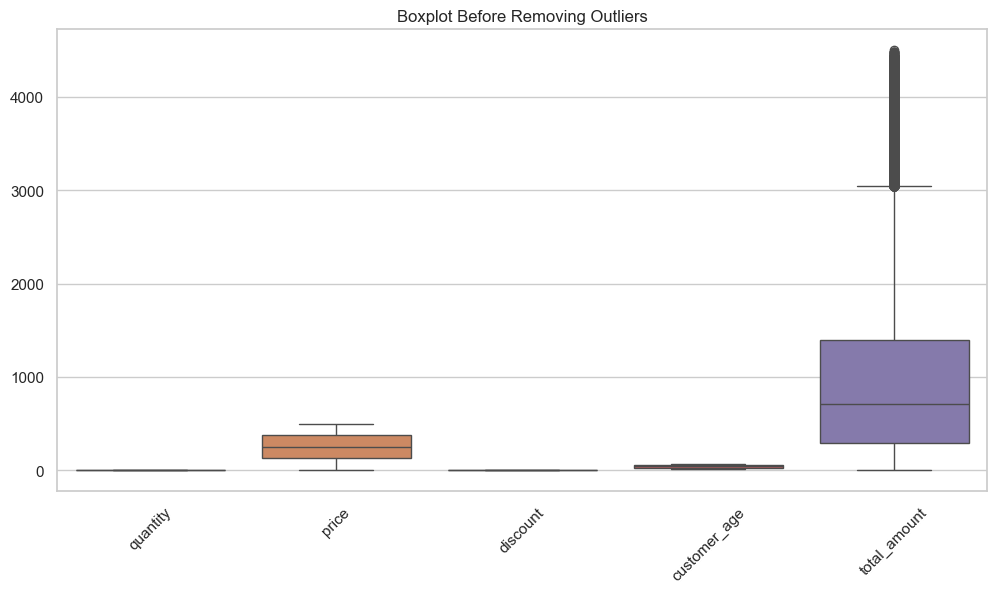

In [20]:
# Boxplot before cleaning
numeric_columns = original_df.select_dtypes(include=[np.number]).columns

# Specify columns to eliminate
columns_to_exclude = ['transaction_id', 'customer_id', 'product_id']  

# Filter out the specified numeric columns
filtered_numeric_columns = [col for col in numeric_columns if col not in columns_to_exclude]

# Create a new DataFrame with the remaining numeric columns
result_df = original_df[filtered_numeric_columns]

plt.figure(figsize=(12,6))
sns.boxplot(data=result_df)
plt.title("Boxplot Before Removing Outliers")
plt.xticks(rotation=45)
plt.show()

In [21]:
def remove_outliers_iqr(df):
    df_filtered = df.copy()

    # For each numeric column, Q1 and Q3 are calculated using quantile(), and then IQR is computed.
    
    for column in numeric_columns:
        Q1 = df_filtered[column].quantile(0.25)  # First quartile (25th percentile)
        Q3 = df_filtered[column].quantile(0.75)  # Third quartile (75th percentile)
        IQR = Q3 - Q1  # Interquartile range
        
        # Define bounds for outliers
        # The lower and upper bounds for identifying outliers are established.
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Remove outliers
        # Rows containing outliers are removed based on these bounds
        df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]

    # Cleaned DataFrame without outliers is returned
    return df_filtered

In [22]:
cleaned_df = remove_outliers_iqr(original_df)

In [23]:
print("Original dataset shape:", original_df.shape)
print("Dataset shape after IQR cleaning:", cleaned_df.shape)

Original dataset shape: (1000000, 16)
Dataset shape after IQR cleaning: (978015, 16)


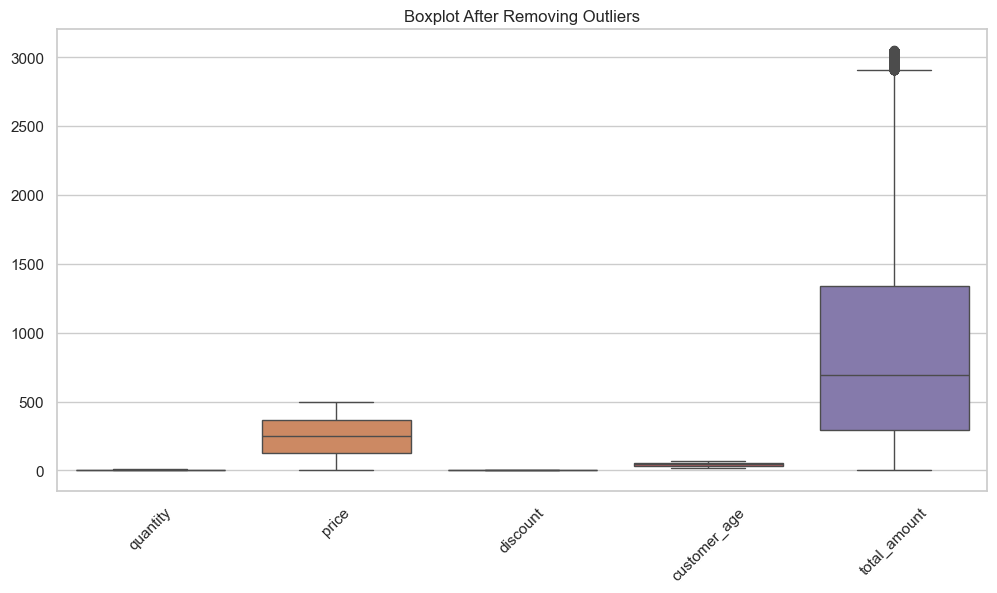

In [24]:
result_df1 = cleaned_df[filtered_numeric_columns]

# Boxplot after cleaning
plt.figure(figsize=(12,6))
sns.boxplot(data=result_df1)
plt.title("Boxplot After Removing Outliers")
plt.xticks(rotation=45)
plt.show()

**Rationale**: Outlier management assures the robustness of analyses, as they can detrimentally affect interpretations and model accuracy. Ensure that the dataset has enough data points after removing outliers; if too many rows are removed, consider adjusting the IQR multiplier or using alternative methods like Z-score or robust statistical techniques.

### Data Preprocessing

**Standardization**, also known as Z-score normalization, involves rescaling the data such that it has a mean **(μ) of 0** and a standard deviation **(σ) of 1**.

This transformation allows the data to be centered around zero, which is particularly useful for algorithms that assume normal distribution or rely on distance metrics. Standardization, is beneficial in scenarios where the dataset contains features with different units or scales.

**Normalization**, often referred to as Min-Max scaling, rescales the features to a specific range, typically **[0, 1]**. In this method, the minimum and maximum values in the dataset are used to ensure that all features contribute equally to the computation.

One key difference between these two techniques is their sensitivity to outliers. Standardization is less affected by outliers since it centers the data based on the mean and standard deviation. Normalization, however, can be significantly influenced by extreme values, as it directly uses the minimum and maximum values of the dataset, which can result in skewed scales.

In [25]:
# rescales the data to a fixed range, typically [0, 1]. 
# to maintain data integrity and prevent anomalies during data operations
# identify numerical columns 
# result_df = original_df[filtered_numeric_columns]

numeric_cols_cleaned = cleaned_df.select_dtypes(include=[np.number]).columns.tolist()

# identify categorical columns
categorical_cols = cleaned_df.select_dtypes(include=['object', 'category']).columns.tolist()

cols_to_process = ['quantity', 'price', 'discount', 'customer_age', 'total_amount']

# Normalizing numerical columns
scaler = MinMaxScaler()
cleaned_df[cols_to_process] = scaler.fit_transform(cleaned_df[cols_to_process])

# Display the normalized DataFrame
cleaned_df.head()

,transaction_id,timestamp,customer_id,product_id,product_category,quantity,price,discount,payment_method,customer_age,customer_location,total_amount,date,customer_gender_female,customer_gender_male,customer_gender_other
0,1,2023-01-01T00:00:00,1993,915,home & kitchen,0.875,0.198586,0.46,gift card,0.176471,north america,0.208064,2023-01-01,True,False,False
1,2,2023-01-01T00:01:00,3474,553,clothing,1.000,0.354101,0.62,gift card,0.686275,south america,0.366699,2023-01-01,False,False,True
2,3,2023-01-01T00:02:00,4564,248,beauty & personal care,0.750,0.154707,0.54,debit card,0.313725,north america,0.136016,2023-01-01,False,False,True
3,4,2023-01-01T00:03:00,1133,948,clothing,0.250,0.465051,0.00,debit card,0.627451,australia,0.230805,2023-01-01,False,False,True
4,5,2023-01-01T00:04:00,3626,284,books,1.000,0.905051,0.68,credit card,0.098039,australia,0.882543,2023-01-01,True,False,False


In [26]:
# Descriptive stat after standardization
cleaned_df[['quantity', 'price', 'discount', 'customer_age', 'total_amount']].describe()


,quantity,price,discount,customer_age,total_amount
count,978015.000000,978015.000000,978015.000000,978015.000000,978015.000000
mean,0.490517,0.490897,0.507241,0.500221,0.291615
std,0.319139,0.285264,0.287515,0.294293,0.238446
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.244323,0.260000,0.254902,0.094477
50%,0.500000,0.489232,0.520000,0.509804,0.226688
75%,0.750000,0.733758,0.760000,0.764706,0.438540
max,1.000000,1.000000,1.000000,1.000000,1.000000


**Rationale**: ___Standardization___ involves converting data into a consistent format, which helps eliminate discrepancies and improve accuracy, while ___Normalization___ organizes data to reduce redundancy and enhance integrity. By applying these processes initially, you ensure that the data is clean and uniform, making subsequent transformations more reliable and meaningful for analysis. This approach not only enhances data quality but also facilitates better performance in data processing and compatibility with analytical tools, ultimately leading to more accurate insights and decisions.

It also is effective to first standardize or normalize your data before performing transformations to achieve a normal-like distribution.

### Data Transformation

**Yeo-Johnson** transformation offers numerous benefits that enhance the efficiency and accuracy of data cleaning processes. Its ability to normalize data distributions, handle varied data types, improve model outcomes, and provide clarity in interpretation makes it an invaluable technique in the field of data analysis.

In [27]:
# Instantiate the Yeo-Johnson transformer
pt = PowerTransformer(method='yeo-johnson')

# Transform the selected numeric columns
cleaned_df[cols_to_process] = pt.fit_transform(cleaned_df[cols_to_process])

# Perform Shapiro-Wilk test on each of the transformed numeric columns
for column in cols_to_process:
    stat, p_value = shapiro(cleaned_df[column])
    print(f'Shapiro-Wilk Test for {column}: Statistics={stat:.3f}, p-value={p_value:.3f}')
    
    # Interpretation of the p-value
    if p_value < 0.05:
        print(f'{column} is likely not normally distributed (reject H0)')
    else:
        print(f'{column} is likely normally distributed (fail to reject H0)')

Shapiro-Wilk Test for quantity: Statistics=0.934, p-value=0.000
quantity is likely not normally distributed (reject H0)
Shapiro-Wilk Test for price: Statistics=0.958, p-value=0.000
price is likely not normally distributed (reject H0)
Shapiro-Wilk Test for discount: Statistics=0.956, p-value=0.000
discount is likely not normally distributed (reject H0)
Shapiro-Wilk Test for customer_age: Statistics=0.954, p-value=0.000
customer_age is likely not normally distributed (reject H0)
Shapiro-Wilk Test for total_amount: Statistics=0.959, p-value=0.000
total_amount is likely not normally distributed (reject H0)


/Users/ai/CODES/PERSONAL/PY/DATAVIZ/sts/venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 978015.
  res = hypotest_fun_out(*samples, **kwds)


#### Sampling

**Standard Sample Size Considerations**

A sample of `358` is sometimes considered standard due to statistical guidelines that help balance accuracy and practicality.
This number can provide a reasonable assurance of representing the population well while allowing for sufficient power in statistical tests.
Depending on the specific research goals, using a `n=358` can yield very reliable data while still being manageable in scale.
Therefore, our group will choose an `n=1000` for given `N=1000000`.

In [28]:
df = cleaned_df.sample(n=1000, random_state=42)  # random_state is optional for reproducibility

In [29]:
print("Shape before sampling:", cleaned_df.shape)
print("Shape after sampling:", df.shape)

Shape before sampling: (978015, 16)
Shape after sampling: (1000, 16)


#### Test for Normality

If the `p-value` is below significance level (e.g., 0.05), reject the H0 and conclude that the data follows non-gaussian distribution.

Researchers often favor the Gaussian distribution in their analyses due to its mathematical convenience, compatibility with natural phenomena, and broad applicability across various fields. One key reason for the preference for Gaussian distribution is the Central Limit Theorem. This theorem posits that the sum of a large number of independent and identically distributed random variables will tend to be normally distributed, regardless of the original distribution's shape.

For this project, we test the dataset for normality using Shapiro-Wilk test and D'Agostino's K-squared test. If the p-value is below significance level (e.g., 0.05), reject the H0 and conclude that the data follows non-gaussian distribution.

In [30]:
# DF for filtered numeric column
df1 = df[filtered_numeric_columns]

# Perform Shapiro-Wilk test
shapiro_results = {}
for col in result_df1:
    stat, p = shapiro(df1[col])
    shapiro_results[col] = (stat, p)

# Perform D'Agostino's K-squared test
dagostino_results = {}
for col in result_df1:
    stat, p = normaltest(df1[col])
    dagostino_results[col] = (stat, p)

# Print results
print("Shapiro-Wilk Test Results:")
for col, result in shapiro_results.items():
    print(f"{col}: stat={result[0]:.4f}, p-value={result[1]:.4f}")

print("\nD'Agostino's K-squared Test Results:")
for col, result in dagostino_results.items():
    print(f"{col}: stat={result[0]:.4f}, p-value={result[1]:.4f}")
    
# if the p-value is below significance level (e.g., 0.05), 
# reject the H0 and conclude that the data is not normally distributed.

Shapiro-Wilk Test Results:
quantity: stat=0.9314, p-value=0.0000
price: stat=0.9552, p-value=0.0000
discount: stat=0.9526, p-value=0.0000
customer_age: stat=0.9550, p-value=0.0000
total_amount: stat=0.9568, p-value=0.0000

D'Agostino's K-squared Test Results:
quantity: stat=1049.2481, p-value=0.0000
price: stat=775.5758, p-value=0.0000
discount: stat=688.6880, p-value=0.0000
customer_age: stat=646.5104, p-value=0.0000
total_amount: stat=419.2168, p-value=0.0000


#### Data Dsitribution

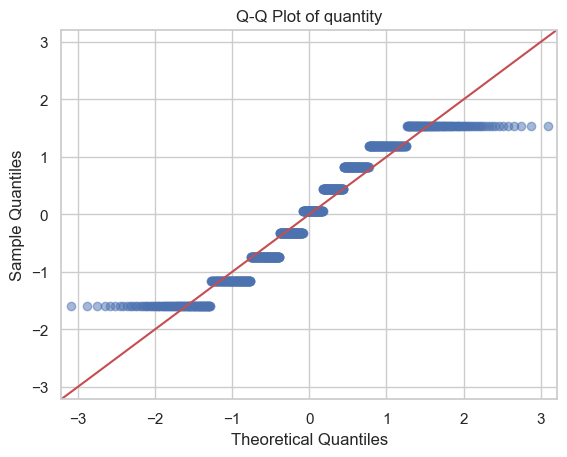

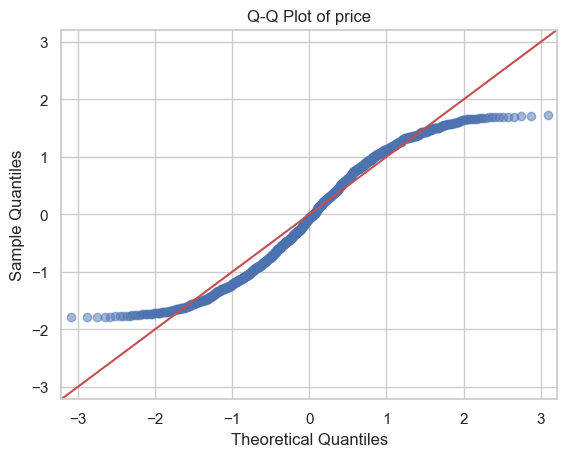

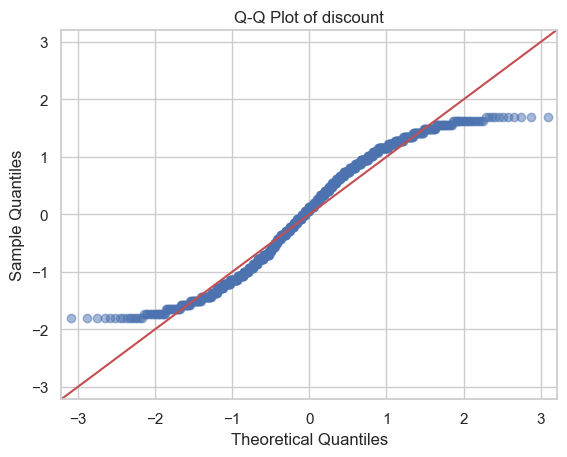

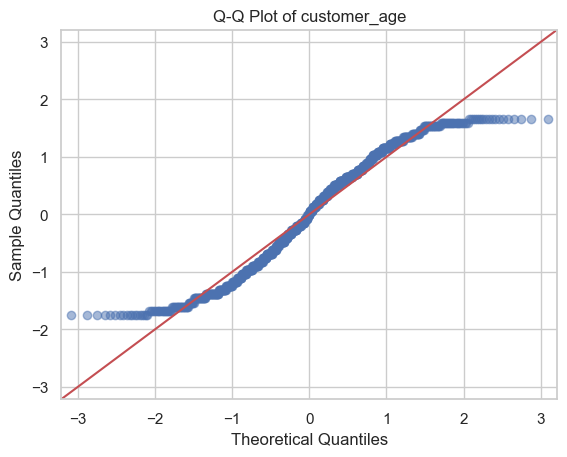

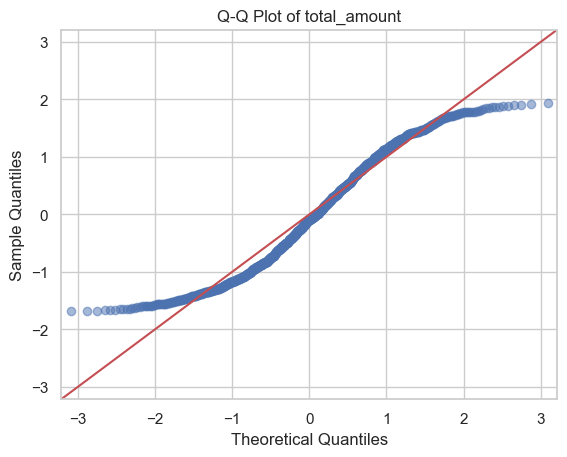

In [31]:
for col in df1.columns:
    sm.qqplot(df[col], line='45', alpha=0.5)
    plt.title(f'Q-Q Plot of {col}')
    plt.show()

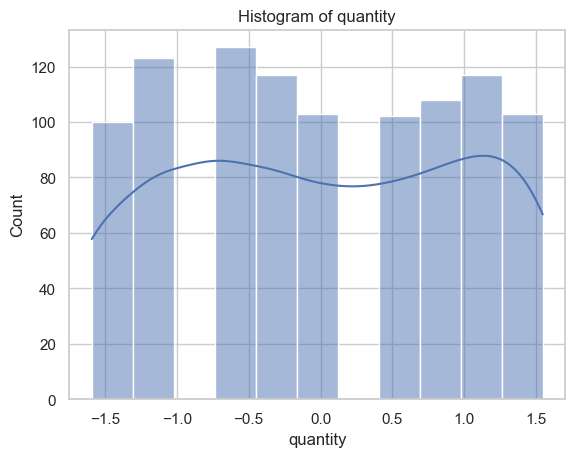

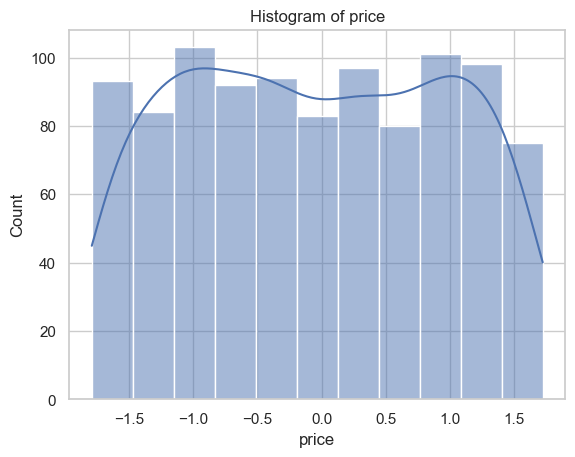

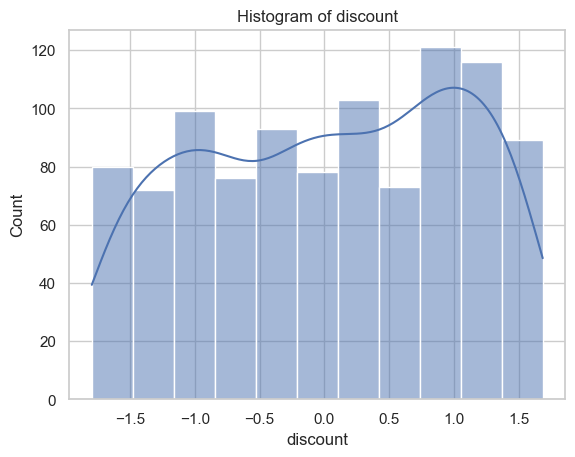

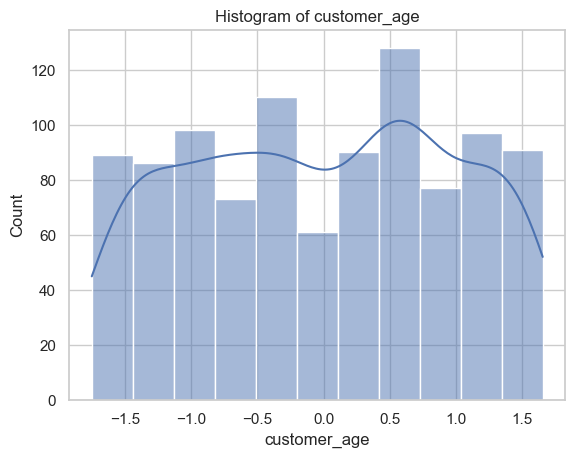

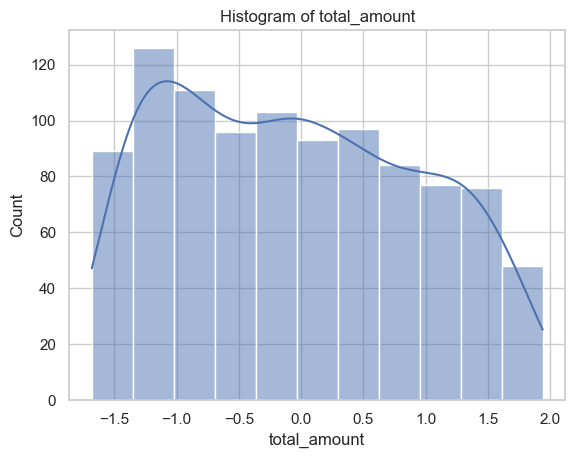

In [32]:
# Histogram
for col in df1.columns:
    plt.figure()
    # plt.hist(df[col], bins=20, color='orange', edgecolor='red', kde=True)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.show()

#### Check for homogeneity of variance

In [33]:
# Perform Levene's test for the selected groups
stat, p_value = levene(df['price'], df['total_amount'], df['customer_age'], df['price'], df['quantity'])

print(f'Levene\'s Test Statistic: {stat:.3f}, p-value: {p_value:.3f}')

# Interpret the p-value
if p_value < 0.05:
    print('The variances are not equal (reject H0).')
else:
    print('The variances are equal (fail to reject H0).')

Levene's Test Statistic: 0.427, p-value: 0.789
The variances are equal (fail to reject H0).


A p-value of 0.789 indicates that there is a 78.9% probability that the observed data would occur under the null hypothesis of equal variances. Since this p-value is much higher than the 0.05 threshold, we can infer that the variances among the groups are likely equal. Consequently, this result allows for the application of parametric tests that assume homogeneity of variance, such as ANOVA and t-tests. The test statistic of 0.427 suggests that the differences in variances among the groups are minor. Since the p-value is far greater than the conventional alpha level of 0.05, we fail to reject the null hypothesis, which states that the variances are equa

#### Check for outliers


In [34]:
for col in df1.columns:
    z_scores = zscore(df[col]) 
    outliers = np.abs(z_scores) > 3
    print(f'Number of outliers for {col}:', sum(outliers))


Number of outliers for quantity: 0
Number of outliers for price: 0
Number of outliers for discount: 0
Number of outliers for customer_age: 0
Number of outliers for total_amount: 0
